# Steph Curry Three Point Shooting Logistic Regression



### Why Logistic Regression?

* It is a statistical technique capable of predicting a binary outcome(shot make or miss).
* From wikipedia: "The binary logistic model is used to estimate the probability of a binary response based on one or more predictor"
* Predictors: 
  - Consecutive seconds Steph Curry has been on the court(stephConsecutiveSeconds)
  - Quarter (PERIOD_x)
  - Minutes remaining in quarter (MINUTES_REMAINING)
* Target: Did the given three point attempt make or miss (SHOT_MADE_FLAG)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
import pylab as pl
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import nbashots as nba # this will throw a warning if using matplotlib 1.5

ImportError: No module named matplotlib

In [81]:
curry_threes = pd.read_csv('/data/bkotecha/threes_with_secondRanges.csv')

In [82]:
curry_threes.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,GRID_TYPE,GAME_ID,EVENTNUM,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,...,stephSubOut,stephSubIn,stephIn,stephOut,timeElapsedBetweenEvents,stephConsecutiveSeconds,endOfQuarter,color,shot_outcome,secondsRange
0,1,66,2174,Shot Chart Detail,21400014,74,201939,Stephen Curry,1610612744,Golden State Warriors,...,False,False,True,False,7,411,False,orangered,MISSED,lessThan8min
1,4,198,2214,Shot Chart Detail,21400014,227,201939,Stephen Curry,1610612744,Golden State Warriors,...,False,False,True,False,6,205,False,orangered,MISSED,lessThan4min
2,7,294,2237,Shot Chart Detail,21400014,349,201939,Stephen Curry,1610612744,Golden State Warriors,...,False,False,True,False,17,102,False,orangered,MISSED,lessThan2min
3,8,319,2241,Shot Chart Detail,21400014,378,201939,Stephen Curry,1610612744,Golden State Warriors,...,False,False,True,False,10,238,False,orangered,MISSED,lessThan4min
4,9,365,2254,Shot Chart Detail,21400014,431,201939,Stephen Curry,1610612744,Golden State Warriors,...,False,False,True,False,6,454,False,cornflowerblue,MADE,lessThan8min


#### Create df w/ the columns we care about

In [83]:
clean_curry_threes = curry_threes[['PERIOD_x', 'MINUTES_REMAINING', 'stephConsecutiveSeconds', 'SHOT_MADE_FLAG']].copy()

In [84]:
clean_curry_threes.head()

,PERIOD_x,MINUTES_REMAINING,stephConsecutiveSeconds,SHOT_MADE_FLAG
0,1,5,411,0
1,2,5,205,0
2,3,10,102,0
3,3,8,238,0
4,3,4,454,1


In [85]:
len(clean_curry_threes)

646

### Take a look at summary statistics

In [87]:
clean_curry_threes.groupby('SHOT_MADE_FLAG').mean()

,PERIOD_x,MINUTES_REMAINING,stephConsecutiveSeconds
SHOT_MADE_FLAG,,,
0,2.330556,4.580556,311.208333
1,2.311189,4.489510,321.615385


In [88]:
clean_curry_threes.groupby('PERIOD_x').mean()

,MINUTES_REMAINING,stephConsecutiveSeconds,SHOT_MADE_FLAG
PERIOD_x,,,
1,5.375000,359.245370,0.430556
2,2.300000,221.075000,0.500000
3,5.346734,350.281407,0.432161
4,3.925926,272.472222,0.416667
5,2.666667,252.666667,0.666667


Mean for SHOT_MADE_FLAG = Steph's 3PT shooting % for each minute of each quarter

In [89]:
clean_curry_threes.groupby(['PERIOD_x','MINUTES_REMAINING']).mean()

stephConsecutiveSeconds  SHOT_MADE_FLAG
PERIOD_x MINUTES_REMAINING                                         
1        0                               586.650000        0.350000
         1                               631.625000        0.500000
         2                               572.300000        0.500000
         3                               515.565217        0.391304
         4                               446.777778        0.500000
         5                               393.052632        0.421053
         6                               333.142857        0.428571
         7                               268.153846        0.461538
         8                               207.300000        0.400000
         9                               149.038462        0.423077
         10                               93.294118        0.352941
         11                               41.000000        0.666667
2        0                               306.241379        0.379310
         1                               272.210526        0.684211
         2                               219.809524        0.571429
         3                               193.500000        0.388889
         4                               158.588235        0.647059
         5                                85.555556        0.333333
         6                               118.200000        0.400000
         7                               263.000000        1.000000
         11                               57.000000        0.000000
3        0                               513.272727        0.363636
         1                               631.444444        0.444444
         2                               549.937500        0.562500
         3                               510.071429        0.500000
         4                               458.380952        0.428571
         5                               396.850000        0.350000
         6                               330.058824        0.352941
         7                               275.764706        0.411765
         8                               209.050000        0.500000
         9                               145.950000        0.400000
         10                               98.764706        0.529412
         11                               25.000000        0.333333
4        0                               416.466667        0.466667
         1                               408.307692        0.384615
         2                               346.230769        0.461538
         3                               334.166667        0.500000
         4                               220.416667        0.250000
         5                               194.727273        0.454545
         6                               156.500000        0.200000
         7                               185.125000        0.375000
         8                               154.666667        0.666667
         9                               115.833333        0.666667
         10                               99.000000        0.333333
         11                               36.000000        0.500000
5        2                               143.000000        1.000000
         3                               307.500000        0.500000

#### Look at 3PT makes and misses by quarter

In [90]:
pd.crosstab(clean_curry_threes['SHOT_MADE_FLAG'], clean_curry_threes['PERIOD_x'], rownames=['SHOT_MADE_FLAG'])

PERIOD_x,1,2,3,4,5
SHOT_MADE_FLAG,,,,,
0,123,60,113,63,1
1,93,60,86,45,2


#### Visualization

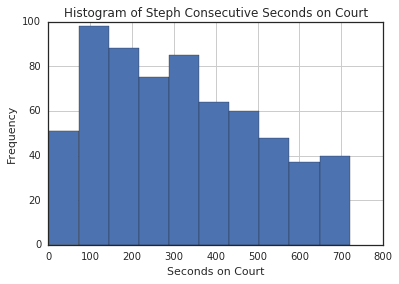

In [91]:
# histogram of seconds
clean_curry_threes.stephConsecutiveSeconds.hist()
plt.title('Histogram of Steph Consecutive Seconds on Court')
plt.xlabel('Seconds on Court')
plt.ylabel('Frequency')

Take a look at distribution of seconds on court for made shots versus missed shots.

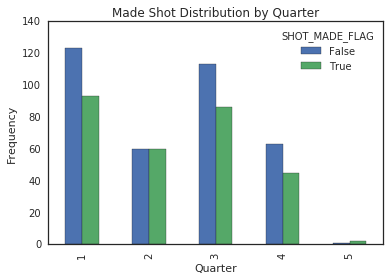

In [92]:
# barplot of quarters grouped by made shot
pd.crosstab(clean_curry_threes.PERIOD_x, clean_curry_threes.SHOT_MADE_FLAG.astype(bool)).plot(kind='bar')
plt.title('Made Shot Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Frequency')

### Prepare Data for Logistic Regression

#### Make Period into "dummy" variable with 5 boolean columns that indicate which period it is. (5 = Overtime) 

In [93]:
dummy_period = pd.get_dummies(clean_curry_threes['PERIOD_x'], prefix='Period')

In [94]:
dummy_period.head()

,Period_1,Period_2,Period_3,Period_4,Period_5
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


#### Drop original period column and merge with dummy period table

In [95]:
del clean_curry_threes['PERIOD_x']
clean_curry_threes.head()

,MINUTES_REMAINING,stephConsecutiveSeconds,SHOT_MADE_FLAG
0,5,411,0
1,5,205,0
2,10,102,0
3,8,238,0
4,4,454,1


In [96]:
data = clean_curry_threes.join(dummy_period.ix[:, 'Period_1':])

In [97]:
data.head()

,MINUTES_REMAINING,stephConsecutiveSeconds,SHOT_MADE_FLAG,Period_1,Period_2,Period_3,Period_4,Period_5
0,5,411,0,1,0,0,0,0
1,5,205,0,0,1,0,0,0
2,10,102,0,0,0,1,0,0
3,8,238,0,0,0,1,0,0
4,4,454,1,0,0,1,0,0


In [98]:
# manually add the intercept (statsmodels requires explicit declaration of intercept)
data['intercept'] = 1.0
data.head()

,MINUTES_REMAINING,stephConsecutiveSeconds,SHOT_MADE_FLAG,Period_1,Period_2,Period_3,Period_4,Period_5,intercept
0,5,411,0,1,0,0,0,0,1
1,5,205,0,0,1,0,0,0,1
2,10,102,0,0,0,1,0,0,1
3,8,238,0,0,0,1,0,0,1
4,4,454,1,0,0,1,0,0,1


In [99]:
#make y into 1-D array of SHOT_MADE_FLAg
y = data['SHOT_MADE_FLAG']
y = np.ravel(y)
del data['SHOT_MADE_FLAG']
y.shape

(646,)

## Performing the Regression
* Predicting shot made from minutes remaining, consecutive seconds on court, and period

First run logistic regression on entire data set

In [100]:
# create logistic regression model, fit with data and y
model = LogisticRegression()
model = model.fit(data, y)

# check the accuracy of training set
model.score(data, y)

0.55263157894736847

In [101]:
# what is steph's 3PT %?
y.mean()

0.44272445820433437

#### That means we could get ~56% accuracy by just guessing a miss every time. 

Take a look at coeffcients

In [102]:
pd.DataFrame(list(zip(data.columns, np.transpose(model.coef_))))

,0,1
0,MINUTES_REMAINING,[0.060761686402]
1,stephConsecutiveSeconds,[0.00123536094757]
2,Period_1,[-0.372083292262]
3,Period_2,[0.250408216922]
4,Period_3,[-0.35352289981]
5,Period_4,[-0.231198757766]
6,Period_5,[0.370303124385]
7,intercept,[-0.336093608531]


A shot being taken in Period 2 seems to increase the likelihood of a made shot. While consecutive seconds played doesn't really seem to have much of an impact. 

### Test/Train Split

In [103]:
# evaluate model by splitting into train and test 
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=0)
model_2 = LogisticRegression()
model_2.fit(data_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [104]:
# predict made shot labels for test set
predicted = model_2.predict(data_test)
predicted

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1])

In [105]:
# generate shot probabilities
probability = model_2.predict_proba(data_test)
probability

array([[ 0.59248446,  0.40751554],
       [ 0.61247524,  0.38752476],
       [ 0.60113742,  0.39886258],
       [ 0.4440176 ,  0.5559824 ],
       [ 0.60066554,  0.39933446],
       [ 0.44348109,  0.55651891],
       [ 0.47971433,  0.52028567],
       [ 0.54355376,  0.45644624],
       [ 0.54594501,  0.45405499],
       [ 0.51526139,  0.48473861],
       [ 0.52248942,  0.47751058],
       [ 0.49849959,  0.50150041],
       [ 0.59071006,  0.40928994],
       [ 0.60644761,  0.39355239],
       [ 0.53271428,  0.46728572],
       [ 0.54042524,  0.45957476],
       [ 0.45849432,  0.54150568],
       [ 0.5250941 ,  0.4749059 ],
       [ 0.5464381 ,  0.4535619 ],
       [ 0.59412454,  0.40587546],
       [ 0.52996526,  0.47003474],
       [ 0.52467571,  0.47532429],
       [ 0.5156178 ,  0.4843822 ],
       [ 0.49967223,  0.50032777],
       [ 0.44826737,  0.55173263],
       [ 0.45473246,  0.54526754],
       [ 0.62660119,  0.37339881],
       [ 0.49905178,  0.50094822],
       [ 0.45202009,

This is predicting a made shot (1) any time column two is greater than 0.5

In [106]:
# evaluation metrics
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probability[:, 1]))

0.505154639175
0.468859649123


#### Still not looking very good. Let's try again with one more predictor.

I want to add current shooting percentage as fourth predictor.

In [107]:
numShots = list(range(1,647))
curry_threes.set_index([numShots])
curry_threes['numShotsTaken'] = pd.Series(numShots, index=curry_threes.index)
curry_threes['curryShotsMade'] = (curry_threes['SHOT_MADE_FLAG'].cumsum())
curry_threes['currentShooting'] = (curry_threes['curryShotsMade']/curry_threes['numShotsTaken'])

In [108]:
clean_curry_threes = curry_threes[['PERIOD_x', 'MINUTES_REMAINING', 
                                   'stephConsecutiveSeconds', 'SHOT_MADE_FLAG','currentShooting']].copy()

In [110]:
clean_curry_threes.head(10)

,PERIOD_x,MINUTES_REMAINING,stephConsecutiveSeconds,SHOT_MADE_FLAG,currentShooting
0,1,5,411,0,0.000000
1,2,5,205,0,0.000000
2,3,10,102,0,0.000000
3,3,8,238,0,0.000000
4,3,4,454,1,0.200000
5,3,0,678,0,0.166667
6,4,2,98,0,0.142857
7,4,1,139,1,0.250000
8,4,0,200,0,0.222222
9,1,6,339,0,0.200000


### Re-do Logistic Regression with current shooting percentage as fourth predictor

#### Prepare Data for Logistic Regression

In [111]:
dummy_period = pd.get_dummies(clean_curry_threes['PERIOD_x'], prefix='Period')

In [112]:
del clean_curry_threes['PERIOD_x']
clean_curry_threes.head()

,MINUTES_REMAINING,stephConsecutiveSeconds,SHOT_MADE_FLAG,currentShooting
0,5,411,0,0.0
1,5,205,0,0.0
2,10,102,0,0.0
3,8,238,0,0.0
4,4,454,1,0.2


In [1]:
data = clean_curry_threes.join(dummy_period.ix[:, 'Period_1':])
data

NameError: name 'clean_curry_threes' is not defined

In [114]:
# manually add the intercept (statsmodels requires explicit declaration of intercept)
data['intercept'] = 1.0
data.head()

,MINUTES_REMAINING,stephConsecutiveSeconds,SHOT_MADE_FLAG,currentShooting,Period_1,Period_2,Period_3,Period_4,Period_5,intercept
0,5,411,0,0.0,1,0,0,0,0,1
1,5,205,0,0.0,0,1,0,0,0,1
2,10,102,0,0.0,0,0,1,0,0,1
3,8,238,0,0.0,0,0,1,0,0,1
4,4,454,1,0.2,0,0,1,0,0,1


In [115]:
#make y into 1-D array of SHOT_MADE_FLAg
y = data['SHOT_MADE_FLAG']
y = np.ravel(y)
# remove shot made from dataframe
del data['SHOT_MADE_FLAG']
y.shape

(646,)

## Performing the Regression
* Predicting shot made from minutes remaining, consecutive seconds on court,period, and current shooting percentage

First run logistic regression on entire data set

In [116]:
# create logistic regression model, fit with data and y
model = LogisticRegression()
model = model.fit(data, y)

# check the accuracy of training set
model.score(data, y)

0.56965944272445823

### Test/Train Split

In [117]:
# evaluate model by splitting into train and test 
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=0)
model_2 = LogisticRegression()
model_2.fit(data_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [118]:
# predict made shot labels for test set
predicted = model_2.predict(data_test)
predicted

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1])

In [119]:
# evaluation metrics
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probability[:, 1]))

0.505154639175
0.468859649123


#### Still not much better than last time

In [120]:
# evaluate model w/ 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), data, y, scoring='accuracy', cv=10)
print (scores)
print (scores.mean())

[ 0.55384615  0.52307692  0.49230769  0.50769231  0.44615385  0.49230769
  0.578125    0.546875    0.578125    0.578125  ]
0.529663461538


###  Conclusion: Steph Curry is too good.